# **EKF Tutorial** #
By Derek Benham

## **Introduction** ##
This tutorial will walk you through the basics of using the Extended Kalman Filter (EKF) in Python. The EKF is a powerful tool for state estimation in robotics. It is a recursive algorithm that uses noisy sensor data to estimate the state of a system. The EKF is an extension of the Kalman Filter (KF) that can be used to estimate the state of nonlinear systems.

Perhaps you've learned about the Kalman Filter which is regarded as the best linear unbiased estimator (BLUE). In the case of a robot moving through a 2D environment, the state of the robot is a 3D vector (x, y, theta) and the environment is no longer linear. The EKF extends the KF by linearizing around it's predicted state using first order taylor series expansion. By creating the space around the predicted state as linear, we can now use our linear algorithms.

### **Environment and Data Set** ###
This tutorial is using a data set created by Tim Barfoot's Autonomous Space Robotics Lab (ASRL) at the University of Toronto. 
The data set can be found at: http://asrl.utias.utoronto.ca/datasets/mrclam/.


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import math

After importing relevant packages, I'm going to load the data set. More information about the data set can be found at the link above but I'll try to make everything self contained here. 

In [2]:
# robot association is an array where each row corresponds a bar code value to a landmark
robot_association = np.loadtxt('datasets/MRCLAM_Dataset1/Barcodes.dat', skiprows=4, dtype='int')
# create empy dictionary
robot_association_dict = {}
# iterate through each row
for row in robot_association:
    # add the key value pair to the dictionary
    robot_association_dict[row[1]] = int(row[0])

# Landmark ground truth (where are the landmarks in the world)
landmark_gt = np.loadtxt('datasets/MRCLAM_Dataset1/Landmark_Groundtruth.dat', skiprows=4, dtype='float')
landmark_dict = {}
for row in landmark_gt:
    landmark_dict[int(row[0])] = row[1:3]

# Robot 1 ground truth
robot_1_gt = np.loadtxt('datasets/MRCLAM_Dataset1/Robot1_Groundtruth.dat', skiprows=4, dtype='float')
# Robot measurements. Each row has a timestep, a landmark ID, and a measurement in the form of range (m) and bearing (rad)
robot1_measurements = np.loadtxt('datasets/MRCLAM_Dataset1/Robot1_Measurement.dat', skiprows=4, dtype='float')

# remove rows in robot1 measurement that correspond to other robots and not landmarks
# This data set was designed for cooperative SLAM but we only care about the single agent Robot 1
robot1_measurements = robot1_measurements[robot1_measurements[:,1] != 14]
robot1_measurements = robot1_measurements[robot1_measurements[:,1] != 41]
robot1_measurements = robot1_measurements[robot1_measurements[:,1] != 32]
robot1_measurements = robot1_measurements[robot1_measurements[:,1] != 23]

# Robot odometry is recorded as: timestep, forward velocity (m/s), angular velocity (rad/s)
robot1_odometry = np.loadtxt('datasets/MRCLAM_Dataset1/Robot1_Odometry.dat', skiprows=4, dtype='float')

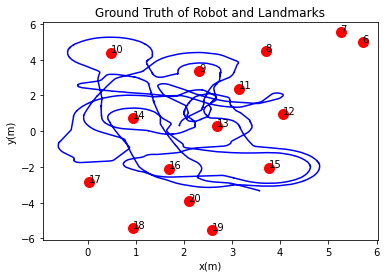

In [3]:
# plot the ground truth landmarks
plt.figure()
# plot circles around the landmarks
# for i in range(landmark_gt.shape[0]):
    # circle = plt.Circle((landmark_gt[i,1], landmark_gt[i,2]), 0.1, color='r', fill=False)
    # plt.gca().add_patch(circle)
plt.plot(landmark_gt[:,1], landmark_gt[:,2], 'r.', markersize=20)
# add labels to the landmarks
for i in range(landmark_gt.shape[0]):
    plt.text(landmark_gt[i,1], landmark_gt[i,2], str(int(landmark_gt[i,0])))

# plot the ground truth robot trajectory
plt.plot(robot_1_gt[:,1], robot_1_gt[:,2], 'b-')


plt.title('Ground Truth of Robot and Landmarks')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.show()

## **Motivation: Dead Reckoning is a Bad Estimate** ##
To demonstrate why we need a probabalistic approach to state estimation we'll begin by comparing the ground truth to the dead reckoning odometry data. You'll see that the odometry data is noisy and will give a bad estimate of the robot's pose after a short time. Most errors come with turning. You'll see that the dead reckoning position estimate stays close until a 90 degree turn is made, then the error accumulates very quickly.

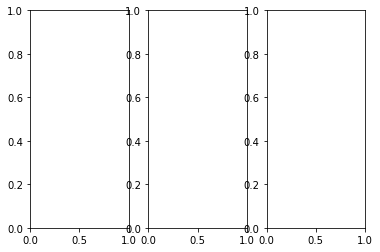

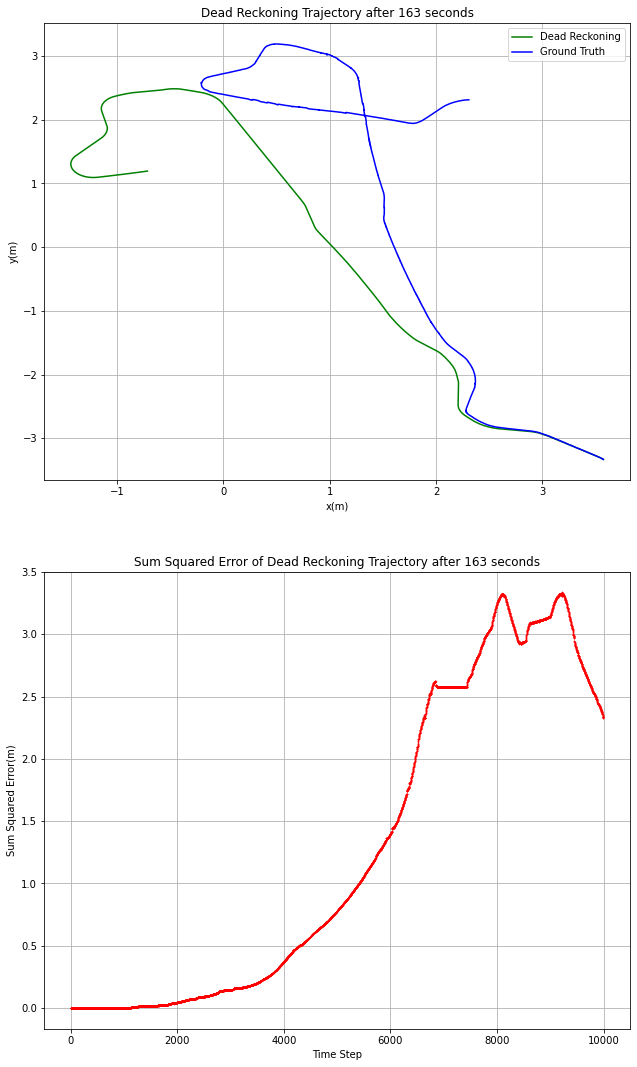

In [8]:
# Define the dead reckoning function
def dead_reckoning(robot1_odometry, initial_x, initial_y, initial_theta):
    x = initial_x # We need to know where the robot is starting from
    y = initial_y
    theta = initial_theta

    positions = np.empty((robot1_odometry.shape[0], 3))
    # Add the initial position to the array
    positions[0] = [x, y, theta]

    for i in range(1, robot1_odometry.shape[0]):
        time_step = robot1_odometry[i,0] - robot1_odometry[i-1,0]
        velocity = robot1_odometry[i,1]
        angular_velocity = robot1_odometry[i,2]
        x += velocity * math.cos(theta) * time_step
        y += velocity * math.sin(theta) * time_step
        theta += angular_velocity * time_step
        positions[i] = [x, y, theta]
    return positions

# Call the dead reckoning function
positions = dead_reckoning(robot1_odometry, robot_1_gt[0,1], robot_1_gt[0,2], robot_1_gt[0,3])

# Create a row of 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig, (ax1, ax2) = plt.subplots(2, 1)
# set the size of the figure
# fig.set_size_inches(18.5, 5.5)
fig.set_size_inches(10.5, 18.5)
seg = 10000 # Segment to only show first little bit of the trajectory
gt_start = 353 # The ground truth starts at this index (when the robot finally started moving)
ax1.plot(positions[:seg,0], positions[:seg,1], 'g-', label='Dead Reckoning')
ax1.plot(robot_1_gt[gt_start:gt_start+seg,1], robot_1_gt[gt_start:gt_start+seg,2], 'b-', label='Ground Truth')
ax1.grid()
seg_to_time = int(robot1_odometry[seg,0] - robot1_odometry[0,0])
title = 'Dead Reckoning Trajectory after {} seconds'.format(seg_to_time)
ax1.set_title(title)
ax1.set_xlabel('x(m)')
ax1.set_ylabel('y(m)')
ax1.legend()


# Ax2
# plot the MSE of the dead reckoning trajectory
sse = []
prev_gt_idx = 0
seg = 10000
for i in range(seg):
    time_step = robot1_odometry[i][0]
    closest_gt_idx = prev_gt_idx
    while robot_1_gt[closest_gt_idx,0] < time_step:
        closest_gt_idx += 1
    sse.append((positions[i,0]- robot_1_gt[closest_gt_idx,1])**2 + (positions[i,1] - robot_1_gt[closest_gt_idx,2])**2)
    prev_gt_idx = closest_gt_idx

seg_to_time = int(robot1_odometry[seg,0] - robot1_odometry[0,0])
# get the MSE of the x and y positions
# sse = (positions[:seg,0]- robot_1_gt[gt_start:gt_start+seg,1])**2 + (positions[:seg,1] - robot_1_gt[gt_start:gt_start+seg,2])**2
ax2.plot(sse, 'r.', markersize=1)
# ax3.plot(mse[0], mse[1], 'r.', markersize=20)
ax2.grid()
ax2.set_title('Sum Squared Error of Dead Reckoning Trajectory after {} seconds'.format(seg_to_time))
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Sum Squared Error(m)')

# # Ax3
# ax3.plot(positions[:,0], positions[:,1], 'g-', label='Dead Reckoning')
# ax3.plot(robot_1_gt[gt_start:,1], robot_1_gt[gt_start:,2], 'b-', label='Ground Truth')
# ax3.grid()
# seg_to_time = int((robot1_odometry[-1,0] - robot1_odometry[0,0])/60)
# title = 'Dead Reckoning Trajectory after {} minutes'.format(seg_to_time)
# ax3.set_title(title)
# ax3.set_xlabel('x(m)')
# ax3.set_ylabel('y(m)')
# ax3.legend()
plt.show()

Here you can see that the dead reckoning odometry data drifts away from the ground truth after a short period of time. A better approach is needed to estimate the robot's pose.

## **The EKF** ##

I'll begin by pasting in the high level algorithm before we start breaking it down into code with further explanations of what's going on.

<!-- Change image size -->
<img src="figures/ekf_algorithm_complete.png" width="600">

### **Motion Step: Updating the Mean** ###

Don't be confused by the notation here. $\theta$ is no longer referring to an angle, it now refers to the state vector $[x,y,\theta]^{T}$. $\theta = (u_{t-1},\theta)$ is saying that the current state is a vector given the motion and previous state. Other notations you might be familiar with are $\theta = f(u_{t-1},\theta_{t-1})$ where $\theta$ is a function of it's previous state and motion model.
 or $P(\theta_{t} | u_{t-1},\theta_{t-1})$.

We need to begin by defining the motion model.

$$ \overline{\mu}_{t} = g(\mu_{t-1}, u_{t}) = \mu_{t-1} + 
\left[\begin{array}{cc} 
v_{t}\Delta t cos(\theta + \frac{\omega_{t} \Delta t}{2})\\
v_{t}\Delta t sin(\theta + \frac{\omega_{t} \Delta t}{2})\\
\omega_{t}\Delta t
\end{array}\right]
$$

$$
\mu_{t-1} = \left[\begin{array}{cc}
x_{t-1}\\
y_{t-1}\\
\theta_{t-1}
\end{array}\right]
$$ 

The robot motion is modeled as if the robot rotates in place, translates and then rotates again. This is a common motion model and works along as $\Delta t$ (our difference in time steps) is small. If you remember, this motion model will give us the "Banana" distribution. Although the EKF isn't designed to model non-Gaussian distributions, it can approximate it close enough. Filters like the Unscented Kalman Filter or the Invariant Extended Kalman Filter are designed to model non-Gaussian distributions better than the standard EKF that we're doing now.

![Alt text](figures/motion_model.png)

In [43]:
def motion_mu_bar(mu_bar, u, dt):
    vt = u[0]
    wt = u[1]

    # u is the odometry
    # mu_bar is the predicted mean
    mu_bar[0] += vt * dt * math.cos(mu_bar[2]+((wt*dt)/2))
    mu_bar[1] += vt * dt * math.sin(mu_bar[2]+((wt*dt)/2))
    mu_bar[2] += wt*dt
    return mu_bar

### **Motion Step: Updating the Covariance** ###

In the previous step we updated our mean. Now we need to update our covariance (our confidence of our location). The covariance is updated using the Jacobian of the motion model. The Jacobian is a matrix that contains the partial derivatives of the motion model with respect to each state variable.

We'll update our covariance using the following equation:

$$
\overline{\Sigma}_{t} = G_{t} \Sigma_{t-1} G_{t}^{T} + V_{t}M_{t}V_{t}^{T}
$$

This may look intimidating, but let's break it down and defining some of these variables. 

Our robot has now moved, so we're less sure of our location compared to before (with no sensor update our error will grow unbounded). In the equation the covariance grows by multiplying our previous covariance by the Jacobian of the motion model $G_{t}$.

$$
G_{t} = \frac{\partial g(\mu_{t}, \mu_{t-1})}{\partial x_{t-1}}
= \left[\begin{array}{cc}
1 & 0 & -v_{t}\Delta t sin(\theta + \frac{\omega_{t} \Delta t}{2})\\
0 & 1 & v_{t}\Delta t cos(\theta + \frac{\omega_{t} \Delta t}{2})\\
0 & 0 & 1
\end{array}\right] 
$$

Now we need to add the noise from our movement. The noise is modeled as a Gaussian distribution with a mean of 0 and a covariance of $V_{t}M_{t}V_{t}^{T}$. The covariance is a diagonal matrix with the following values:

$$ M_{t} = \left[\begin{array}{cc}
\alpha_{1}v_{t}^{2} + \alpha_{2}\omega_{t}^{2} & 0\\
0 & \alpha_{3}v_{t}^{2} + \alpha_{4}\omega_{t}^{2}
\end{array}\right] $$

With this data set we were not given the noise values of our vehicle so we will need to tune these alpha values.

Since $M_{t}$ is in control space, we need to map it into state space. This is done by multiplying $M_{t}$ by $V_{t}$.
$V_{t}$ is the Jacobian of the motion model with respect to the motion parameters $\mu_{t}$.

$$ V_{t} = \frac{\partial g(\mu_{t}, \mu_{t-1})}{\partial u_{t}}

= \left[\begin{array}{cc}
cos(\theta+\frac{\omega+{t} \Delta t}{2}) & -\frac{1}{2}sin(\theta+\frac{\omega_{t} \Delta t}{2}) \\

sin(\theta+\frac{\omega+{t} \Delta t}{2}) & \frac{1}{2}cos(\theta+\frac{\omega_{t} \Delta t}{2}) \\
0 & 1
\end{array}\right] $$

The above example of $V_{t}$ is different than the one in Probabalistic Robotics. In the textbook the motion model divides by $\omega_{t}$ with the assumption that the robot is always moving in an arc. That's not the case for this data set so I used a modified motion model borrowed from Andrew J Kramer. http://andrewjkramer.net/intro-to-the-ekf-step-1/ 
I need to learn more about what he did exactly.


In [44]:
def motion_sigma_bar(sigma_bar, mu_bar, u, dt, alphas):
    vt = u[0]
    wt = u[1]

    g_t = np.array([[1, 0, -vt*dt*np.sin(mu_bar[2]+((wt*dt)/2))],
                    [0, 1, vt*dt*np.cos(mu_bar[2]+((wt*dt)/2))],
                    [0, 0, 1]])
    
    m_t = np.array([[(alphas[0]*abs(vt) + alphas[1]*abs(wt))**2, 0],
                    [0, (alphas[2]*abs(vt) + alphas[3]*abs(wt))**2]])
    
    v_t = np.array([[np.cos(mu_bar[2]+((wt*dt)/2)), -0.5*np.sin(mu_bar[2]+((wt*dt)/2))],
                    [np.sin(mu_bar[2]+((wt*dt)/2)), 0.5*np.cos(mu_bar[2]+((wt*dt)/2))],
                    [0, 1]])

    sigma_bar = (g_t @ sigma_bar @ g_t.T) + (v_t @ m_t @ v_t.T)

    return sigma_bar

### **Sensor Update: Sensor Model** ###


$Q_{t}$ is the covariance of the sensor model. It represents the constant noise from our sensor. It is a diagonal matrix of $\sigma_{range}^{2}$, $\sigma_{bearing}^{2}$ and $\sigma_{marker ID}^{2}$.

In [45]:
sigma_range = 2
sigma_bearing = 3
sigma_id = 1
Q_t = [[sigma_range^2, 0, 0,],
       [0, sigma_bearing^2, 0],
       [0, 0, sigma_id^2]]

### Iterate over every observable feature at time step t ###



In this dataset, measurements are recorded as a range, bearing, and marker ID. $z_{t}^{i} = (r_{t}^{i}, \phi_{t}^{i}, s_{t}^{i})$. We are currently assuming we have known data correspondences between the features in the map and the features recorded by the sensor (we know what sensor we're looking at). This is a poor assumption in the real world and will need to be addressed in the future. This process is called data association.

#### Generating the Expected Measurement ####
$$j=c_{t}^{i}$$
$c_{t}^{i}$ is the index of the feature in the map that corresponds to the sensor measurement $z_{t}^{i}$. We will use this index to access the feature in the map.

$$q = (m_{j,x}-\bar{\mu_{t,x}})^{2} + (m_{j,y}-\bar{\mu}_{t,y})^{2}$$

<!-- make a 3x1 matrix -->
$$\hat{z}_{t}^{i} = \left[\begin{array}{cc}
\sqrt{q}\\
atan2(m_{j,y}-\bar{\mu}_{t,y}, m_{j,x}-\bar{\mu}_{t,x}) - \bar{\mu}_{t,\theta}\\
m_{j,s}
\end{array}\right]$$

Now we want to calculate what we expect the measurement to be given the belief of our current state. q is the distance euclidean distance between the feature in the map and the robot. Then we can calculate the expected bearing using the atan2 function. The expected marker ID is just the marker ID of the feature in the map.

#### Calculating the Jacobian ####

We need to calculate the noise associated with the measurement. $H_{t}^{i}$ is the Jacobian of the sensor model with respect to the state variables. It is a 3x3 matrix. The state variables are the robot's x position, y position, and heading. The Jacobian is calculated using the chain rule.

$$H_{t}^{i} = \frac{\partial h(\mu_{t}, m)}{\partial x_{t}} = 
\left[\begin{array}{cc}
- \frac{m_{j,x}-\bar{\mu}_{t,x}}{\sqrt{q}} & - \frac{m_{j,y}-\bar{\mu}_{t,y}}{\sqrt{q}} & 0\\
\frac{m_{j,y}-\bar{\mu}_{t,y}}{q} & - \frac{m_{j,x}-\bar{\mu}_{t,x}}{q} & -1\\
0 & 0 & 0
\end{array}\right]$$

### **Sensor Update: Kalman Gain** ###
Now that we've updated our mean and covariance, we need to update our estimate using the sensor data. The sensor data is used to update our mean and covariance. The Kalman Gain is used to determine how much we should trust the sensor data. The Kalman Gain is a scalar that is multiplied by the sensor data to update our mean and covariance. The Kalman Gain is calculated using the following equation:

$$ K_{t} = \frac{Error_{motion}}{Error_{motion} + Error_{sensor}} $$

First lets calculate the innovation covariance, also known as the measurement residual covariance matrix. It is used to represent the uncertainty or variance of the difference between the predicted measurement and the actual measurement at each time step.

The innovation S is represented as 
$$ S_{t} = H_{t}^{i}\bar{\Sigma}_{t}[H_{t}^{i}]^{T} + Q_{t} $$

The Kalman Gain is calculated as

$$ K_{t}^{i} = \bar{\Sigma}_{t}[H_{t}^{i}]^{T}[S_{t}^{i}]^{-1} $$

### **Sensor Update: Updating Belief** ###

The last step is to update our belief using the Kalman Gain. 
$$ \bar{\mu}_{t} = \bar{\mu}_{t} + K_{t}^{i}(z_{t}^{i} - \hat{z}_{t}^{i}) $$

$$ \bar{\Sigma}_{t} = (I - K_{t}^{i}H_{t}^{i})\bar{\Sigma}_{t} $$

A quick reminder on variables, 

$\hat{z}_{t}^{i}$ is the expected measurement, 

$z_{t}^{i}$ is the actual measurement, 

$K_{t}^{i}$ is the Kalman Gain

$H_{t}^{i}$ is the Jacobian of the sensor model with respect to the state variables. It is a 3x3 matrix. The state variables are the robot's x position, y position, and heading. The Jacobian is calculated using the chain rule.

$Q_{t}$ is the covariance of the sensor model. It represents the constant noise from our sensor. It is a diagonal matrix of $\sigma_{range}^{2}$, $\sigma_{bearing}^{2}$ and $\sigma_{marker ID}^{2}$.

$\bar{\mu}_{t}$ is the mean of our belief.

$\bar{\Sigma}_{t}$ is the covariance of our belief.

<!-- <img src="figures/ekf_algorithm_pt2.png" width="600"> -->

<!-- <img src="figures/ekf_algorithm_pt3.png" width="600"> -->


In [46]:
# For every sensor reading at time step t:
# Z is sensor reading (range, bearing, subject)
def sensor_reading(mu_bar, sigma_bar, z, Q, landmarks):
    try:
        landmark_id = robot_association_dict[int(z[0])]
        landmark = landmark_dict[landmark_id]
    except KeyError:
        return mu_bar, sigma_bar
    q = (landmark[0] - mu_bar[0])**2 + (landmark[1] - mu_bar[1])**2
    z_hat = np.array([math.sqrt(q), math.atan2(landmark[1] - mu_bar[1], landmark[0] - mu_bar[0]) - mu_bar[2]])
    
    h_t = np.array([[-(landmark[0] - mu_bar[0])/math.sqrt(q), -(landmark[1] - mu_bar[1])/math.sqrt(q), 0],
                    [(landmark[1] - mu_bar[1])/q, - (landmark[0] - mu_bar[0])/q, -1],
                    [0, 0, 0]])
    
    S_t = h_t @ sigma_bar @ h_t.T + Q

    K_t = sigma_bar @ h_t.T @ np.linalg.inv(S_t)  # Kalman Gain, inverting a matrix, will look to optimize this later

    z_diff = z[1:] - z_hat
    # add a 0 to the end of the z_diff to account for the id
    z_diff = np.append(z_diff, 0)

    mu_bar = mu_bar.reshape(3,1) + K_t @ z_diff.reshape(3,1)

    sigma_bar = (np.eye(3) - (K_t @ h_t)) @ sigma_bar

    return mu_bar.reshape(3), sigma_bar    

After iterating over every observable feature at time step t, we can set our mean and covariance to the updated values and move on to the next time step.

$$ \mu_{t} = \bar{\mu}_{t} $$
$$ \Sigma_{t} = \bar{\Sigma}_{t} $$

The algorithm at the top includes code to calculate the measurement probability, but we won't use that in this project.

In [48]:
alphas = [.2, .03, .09, .08] # robot-dependent motion noise 
sigma_range = 2;
sigma_bearing = 3;
sigma_id = 1;

# robot-dependent sensor noise parameters
sigma_range = 2;
sigma_bearing = 3;
sigma_id = 1;

Q_t = np.diag([sigma_range^2, sigma_bearing^2, sigma_id^2])

def EKF(robot_odometry, initial_x, initial_y, initial_theta, robot_measurements, animate=False):
    
    # We need to find when the robot measurements and odometry line up
    measurement_starting_idx = 0
    starting_timestep = robot_odometry[0,0]
    for i in range(robot_measurements.shape[0]):
        if robot_measurements[i,0] > starting_timestep:
            measurement_starting_idx = i
            break
    robot_measurements = robot_measurements[measurement_starting_idx:-1] # Robot measurements are now in sync with odometry data
    
    # x = initial_x # We need to know where the robot is starting from
    # y = initial_y
    # theta = initial_theta
    mu_bar = np.array([initial_x, initial_y, initial_theta])

    sigma_bar = np.array([[0.01, 0.01, 0.01],
                          [0.01, 0.01, 0.01],
                          [0.01, 0.01, 0.01]])

    positions = np.empty((robot1_odometry.shape[0], 3))
    # Add the initial position to the array
    positions[0] = mu_bar
    measurement_idx = 0

    # Time to actually iterate through the data
    for i in range(1, robot_odometry.shape[0]):
        # Motion step
        dt = robot_odometry[i,0] - robot_odometry[i-1,0]
        mu_bar = motion_mu_bar(mu_bar, [robot_odometry[i][1], robot_odometry[i][2]], dt)
        sigma_bar = motion_sigma_bar(sigma_bar, mu_bar, [robot_odometry[i][1], robot_odometry[i][2]], dt, alphas)
        
        # Check to see if we have a sensor reading at this time step
        while(robot_odometry[i][0] >= robot_measurements[measurement_idx+1][0]):
            # Correction Step
            measurement_idx += 1
            mu_bar, sigma_bar = sensor_reading(mu_bar, sigma_bar, robot_measurements[measurement_idx][1:], Q_t, landmark_dict)
        
            if measurement_idx >= robot_measurements.shape[0]-5: # The end of the data set gets a little weird.
                return positions

        positions[i] = mu_bar
    return positions

# sensor_reading(mu_bar, sigma_bar, z, Q, landmarks):
robot1_odometry = robot1_odometry[600:-1]
# find the starting GT position
gt_index = 0
while robot_1_gt[gt_index,0] < robot1_odometry[0,0]:
    gt_index += 1
ekf_positions = EKF(robot1_odometry, robot_1_gt[gt_index,1], robot_1_gt[gt_index,2], robot_1_gt[gt_index,3], robot1_measurements)


/tmp/ipykernel_32847/3228327085.py:26: RuntimeWarning: invalid value encountered in matmul
  sigma_bar = (np.eye(3) - (K_t @ h_t)) @ sigma_bar


ValueError: math domain error

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:

# plot the ground truth landmarks
plt.figure()
index = 1000
# plot circles around the landmarks
# for i in range(landmark_gt.shape[0]):
    # circle = plt.Circle((landmark_gt[i,1], landmark_gt[i,2]), 0.1, color='r', fill=False)
    # plt.gca().add_patch(circle)
plt.plot(landmark_gt[:,1], landmark_gt[:,2], 'r.', markersize=20)
# add labels to the landmarks
for i in range(landmark_gt.shape[0]):
    plt.text(landmark_gt[i,1], landmark_gt[i,2], str(int(landmark_gt[i,0])))

# plot the ground truth robot trajectory
plt.plot(robot_1_gt[gt_index:index,1], robot_1_gt[gt_index:index,2], 'b-', label='Ground Truth')

# plot dead reckoning
positions_dr = dead_reckoning(robot1_odometry, robot_1_gt[gt_index,1], robot_1_gt[gt_index,2], robot_1_gt[gt_index,3])
plt.plot(positions_dr[:index,0], positions_dr[:index,1], 'y-', label='Dead Reckoning')

# plot the EKF robot trajectory
plt.plot(ekf_positions[:index,0], ekf_positions[:index,1], 'g-', label='EKF')


plt.legend()
plt.title('EKF')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
# make the plot big!
plt.gcf().set_size_inches(12, 12)
# plt.show()

# plt.figure()
# # plot circles around the landmarks
# # for i in range(landmark_gt.shape[0]):
#     # circle = plt.Circle((landmark_gt[i,1], landmark_gt[i,2]), 0.1, color='r', fill=False)
#     # plt.gca().add_patch(circle)
# plt.plot(landmark_gt[:,1], landmark_gt[:,2], 'r.', markersize=20)
# # add labels to the landmarks
# for i in range(landmark_gt.shape[0]):
#     plt.text(landmark_gt[i,1], landmark_gt[i,2], str(int(landmark_gt[i,0])))

# # plot the ground truth robot trajectory
# plt.plot(robot_1_gt[:,1], robot_1_gt[:,2], 'b-', label='Ground Truth')

# # plot the EKF robot trajectory
# plt.plot(ekf_positions[:5000,0], ekf_positions[:5000,1], 'g-', label='EKF')
# plt.legend()
plt.xlim(-1, 6)
plt.ylim(-6, 6)
plt.show()

Discuss how I handle the seperation of timesteps since odometry measurements are much more frequent than landmark measurements.

EKF Algorithm:
$$ \theta_{t} = u_{t-1, \theta} $$
$$ G_{t} = \left[\begin{array}{cc}
1 & 0 & -v_{t}\triangle t sin(\theta+\frac{\omega_{t}\triangle t}{2}) \\
0 & 1 & v_{t}\triangle t cos(\theta+\frac{\omega_{t}\triangle t}{2}) \\
0 & 0 & 1
\end{array}\right] $$
$$ V_{t} = \left[\begin{array}{cc}
cos(\theta+\frac{\omega_{t}\triangle t}{2}) & -\frac{1}{2}sin(\theta+\frac{\omega_{t}\triangle t}{2})\triangle t \\
sin(\theta+\frac{\omega_{t}\triangle t}{2}) & \frac{1}{2}cos(\theta+\frac{\omega_{t}\triangle t}{2})\triangle t \\
0 & 1
\end{array}\right] $$
$$ M_{t} = \left[\begin{array}{cc}
\alpha_{1}v_{t}^{2} + \alpha_{2}\omega_{t}^{2} & 0 \\
0 & \alpha_{3}v_{t}^{2} + \alpha_{4}\omega_{t}^{2}
\end{array}\right] $$

$$ \bar{\mu}_{t} = \mu_{t-1} + \left[\begin{array}{cc}
v_{t}\triangle t cos(\theta+\frac{\omega_{t}\triangle t}{2}) \\
v_{t}\triangle t sin(\theta+\frac{\omega_{t}\triangle t}{2}) \\
\omega_{t}\triangle t
\end{array}\right] $$

$$ \bar{\Sigma}_{t} = G_{t}\Sigma_{t-1}G_{t}^{T} + V_{t}M_{t}V_{t}^{T} $$

$$ Q_{t} = \left[\begin{array}{cc}
\sigma_{r}^{2} & 0 & 0\\
0 & \sigma_{\phi}^{2} & 0\\
0 & 0 & \sigma_{s}^{2}
\end{array}\right] $$


for all observed features $z_{t}^{i} = (r_{t}^{i}, \phi_{t}^{i}, s_{t}^{i})$:

$$ q = (m_{j,x}-\bar{\mu}_{t,x})^{2} + (m_{j,y}-\bar{\mu}_{t,y})^{2} $$

$$ \hat{z}_{t}^{i} = \left[\begin{array}{cc}
\sqrt{q} \\
atan2(m_{j,y}-\bar{\mu}_{t,y}, m_{j,x}-\bar{\mu}_{t,x}) - \bar{\mu}_{t,\theta} \\
m_{j,s}
\end{array}\right] $$

$$ H_{t}^{i} = \left[\begin{array}{cc}
-\frac{m_{j,x}-\bar{\mu}_{t,x}}{\sqrt{q}} & -\frac{m_{j,y}-\bar{\mu}_{t,y}}{\sqrt{q}} & 0 \\
\frac{m_{j,y}-\bar{\mu}_{t,y}}{q} & -\frac{m_{j,x}-\bar{\mu}_{t,x}}{q} & -1 \\
0 & 0 & 0
\end{array}\right] $$

$$ S_{t}^{i} = H_{t}^{i}\bar{\Sigma}_{t}[H_{t}^{i}]^{T} + Q_{t} $$

$$ K_{t}^{i} = \bar{\Sigma}_{t}[H_{t}^{i}]^{T}[S_{t}^{i}]^{-1} $$

$$ \bar{\mu}_{t} = \bar{\mu}_{t} + K_{t}^{i}(z_{t}^{i} - \hat{z}_{t}^{i}) $$

$$ \bar{\Sigma}_{t} = (I - K_{t}^{i}H_{t}^{i})\bar{\Sigma}_{t} $$

end for

$$ \mu_{t} = \bar{\mu}_{t} $$
$$ \Sigma_{t} = \bar{\Sigma}_{t} $$
return $\mu_{t}$, $\Sigma_{t}$